In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [2]:
import os
if not os.path.exists("./stan120"):
    os.mkdir("./stan120")

In [3]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')

In [4]:
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [5]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [6]:
Y.head

<bound method NDFrame.head of       Count_120  idSensore  Year  Month
0             4       5707  2010      4
1             8       5707  2010      5
2            16       5707  2010      6
3            25       5707  2010      7
4            12       5707  2010      8
...         ...        ...   ...    ...
3835         16      12020  2022      6
3836         28      12020  2022      7
3837          6      12020  2022      8
3838          3      12020  2022      9
3839          0      12020  2022     10

[3840 rows x 4 columns]>

In [7]:
stations = Y['idSensore']
years = Y['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = stations
stations = transformed_stations

In [8]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan120/base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

15:35:09 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\base.exe
15:35:32 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\base.exe


In [9]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X
}


fit_base = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=200, iter_sampling=300)
posterior_base_az = az.from_cmdstanpy(fit_base)

15:35:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:35:45 - cmdstanpy - INFO - CmdStan done processing.


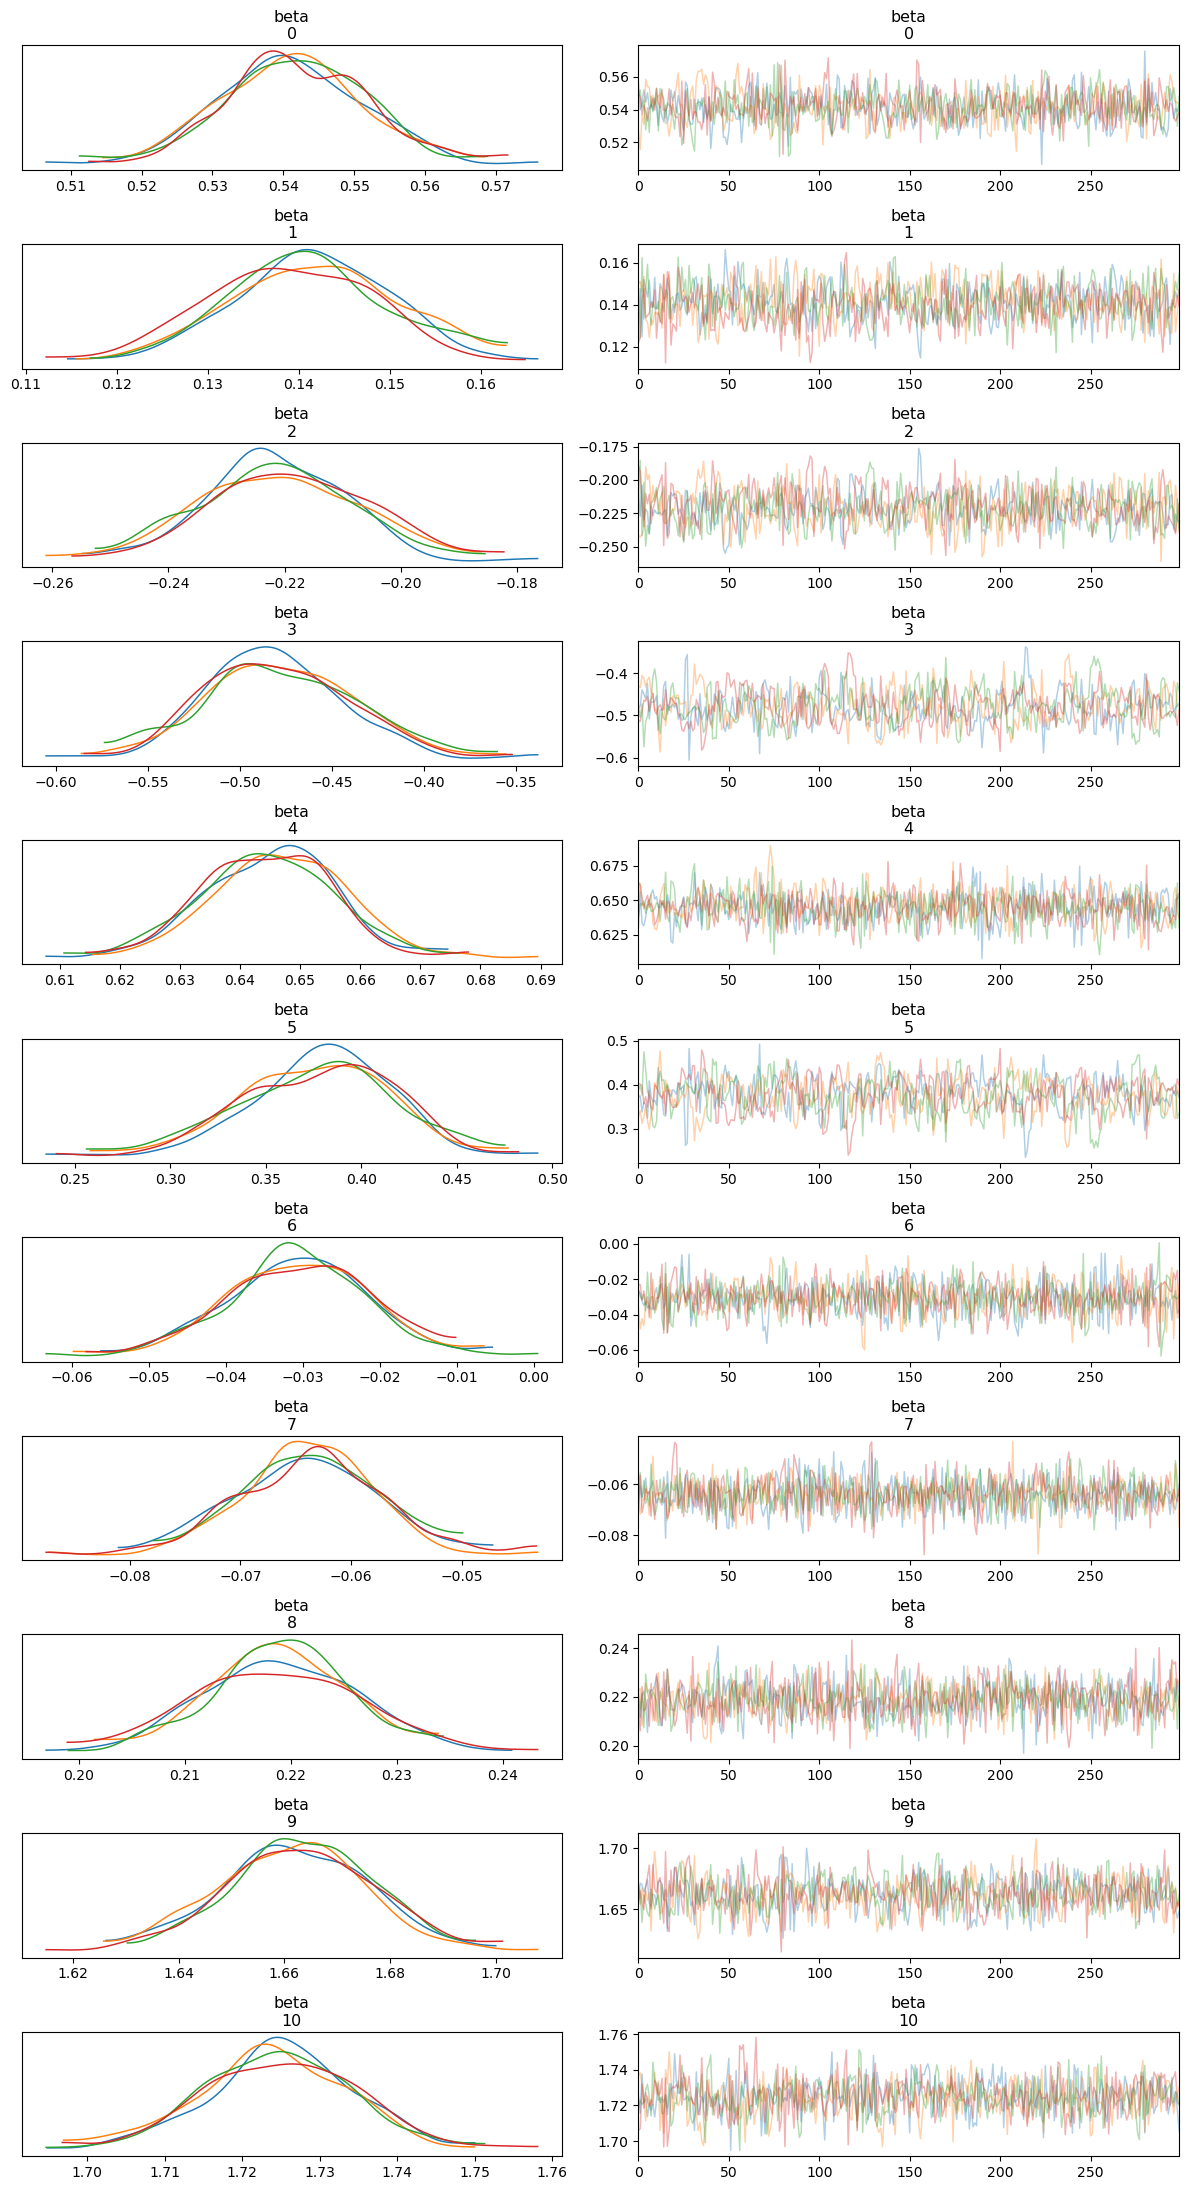

In [10]:
az.plot_trace(posterior_base_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [11]:
log_lik = fit_base.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


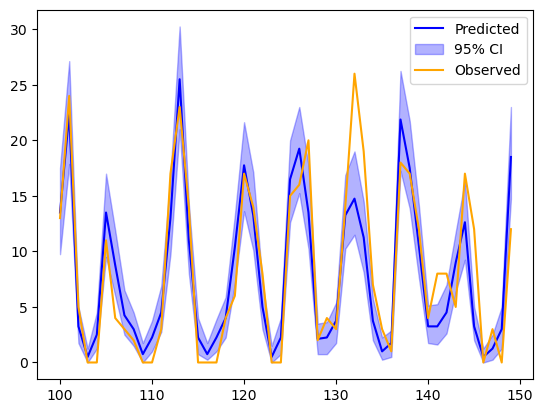

In [12]:
preds_y = posterior_base_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(100, 150)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_120'], label="Observed", color='orange')
plt.legend()
plt.show()

In [13]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_base, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_base, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 1200 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13593.44   235.61
p_waic       41.76        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 1200 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13593.62   235.61
p_loo       41.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [84]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)
preds_y = posterior_base_az['posterior']['y_pred'].mean(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)

in_ci = np.logical_and(Y['Count_120'] >= y_star_low, Y['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Inizializza un DataFrame vuoto
results_df = pd.DataFrame(columns=['Model', 'Percentage in CI', 'WAIC', 'LOO', 'MAD Median'])

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Base'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 43.88%
Mean Absolute Deviation (MAD) sulla mediana: 3.78505859375
          Model  Percentage in CI          WAIC           LOO  MAD Median
0  Modello Base         43.880208 -10100.463033 -10100.585184    3.785059


C:\Users\leoma\AppData\Local\Temp\ipykernel_9440\1832784943.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_data], ignore_index=True)


Now we remove some variables, through two methods:\
    1. Variable selection through **SSVS**\
    2. Hard shrinkage in the posterior of the betas   
    
The code for the SSVS is on R in its folder, while the hard shrinkage will be in this file.

Given the SSVS paradigm, the covariates to remove are *max_consecutive_highwind_days*, *Densità*, *count_highwind*

In [14]:
##Code for hard shrinkage, hopefully same result
X.head

<bound method NDFrame.head of       mean_temperature  mean_precipitation_sum  mean_precipitation_hours  \
0            -1.415564               -0.613095                 -0.033854   
1            -0.664023                2.562416                  2.016839   
2             0.441882               -0.190293                  0.325219   
3             1.467529               -1.011831                 -0.989703   
4             0.543283                1.328997                  0.370040   
...                ...                     ...                       ...   
3835          1.357083               -0.743306                 -1.189132   
3836          1.994391               -1.624094                 -1.865982   
3837          1.461331               -0.779083                 -1.125677   
3838          0.232652               -0.345014                 -0.642717   
3839         -0.349283               -1.091885                 -1.488275   

      mean_windspeed_10m_max  mean_radiation_sum  count_h

In [15]:
X = X.drop(columns=['max_consecutive_highwind_days', 'Densità', 'type_rural', 'type_urban'])

In [16]:
var_sel_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;

    fix_eff = X * beta;

    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}


"""

stan_file = "./stan120/var_sel_base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

var_sel_base = CmdStanModel(stan_file=stan_file)

15:35:59 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\var_sel_base.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\var_sel_base.exe
15:36:24 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\var_sel_base.exe


In [17]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X
}


fit_var_sel = var_sel_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_val_sel_az = az.from_cmdstanpy(fit_var_sel)

15:36:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:36:39 - cmdstanpy - INFO - CmdStan done processing.


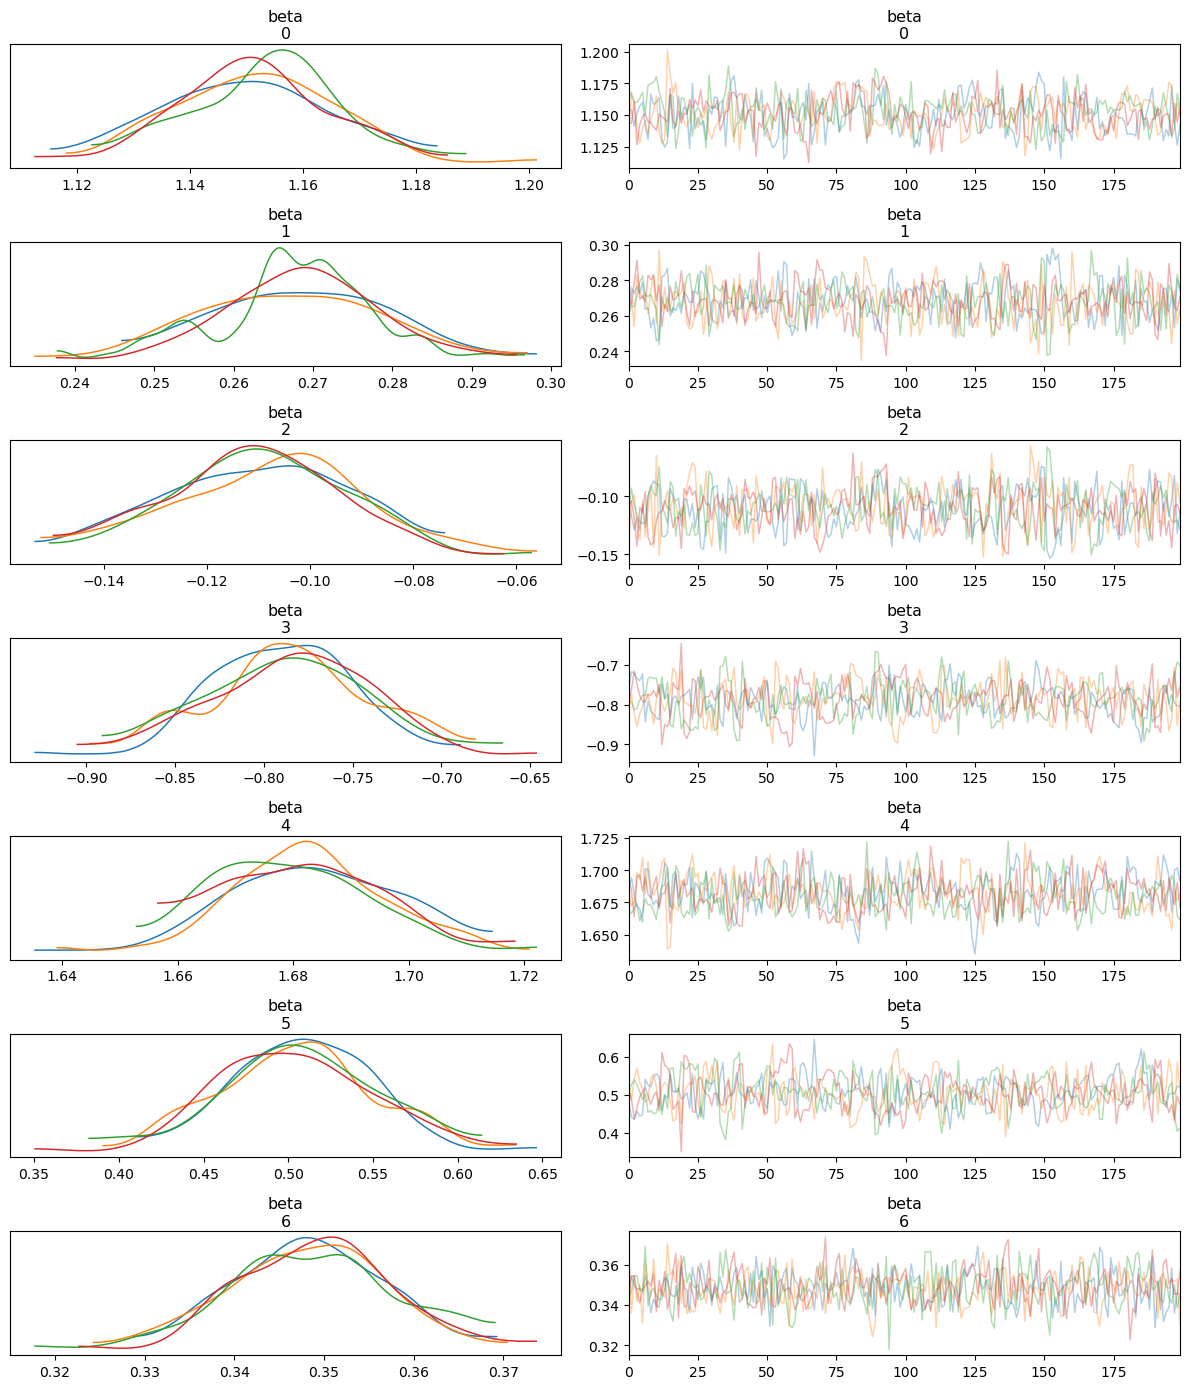

In [18]:
az.plot_trace(posterior_val_sel_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [19]:
log_lik = fit_var_sel.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


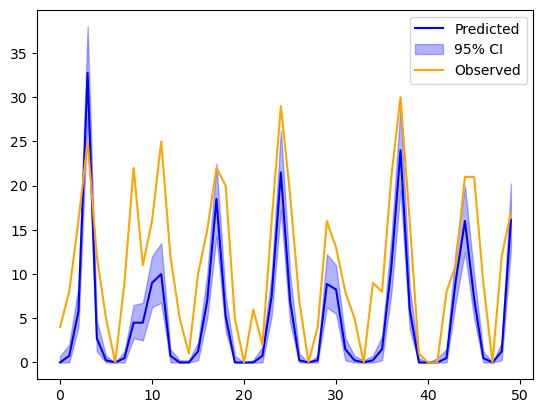

In [20]:
preds_y = posterior_val_sel_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_120'], label="Observed", color='orange')
plt.legend()
plt.show()

In [21]:
# Crea un oggetto InferenceData contenente log_lik
#inference_data = az.from_cmdstanpy(fit, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_var_sel, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_var_sel, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -24873.76   476.92
p_waic       75.33        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -24873.62   476.90
p_loo       75.20        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3839  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [86]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)
preds_y = posterior_val_sel_az['posterior']['y_pred'].mean(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)

in_ci = np.logical_and(Y['Count_120'] >= y_star_low, Y['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Variable Selection'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 35.62%
Mean Absolute Deviation (MAD) sulla mediana: 5.05869140625
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         43.880208 -10100.463033 -10100.585184   
1  Modello Variable Selection         35.625000 -10100.463033 -10100.585184   

   MAD Median  
0    3.785059  
1    5.058691  


# Fit improvement
The threshold of 180 is very unlikely to be overcomed, with respect to the 120-threshold.\
This result in the presence of more zeros, and indeed *too much zeros*.\
The method for overcoming this issue is the **zero inflated Poisson** and the following is the code to implement this metodologies.

In [22]:
#Code for improve the fit

## Year model:
We add the factor accounting for different years.

In [23]:
year_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;

  array[N] int<lower=1> year;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}


"""

stan_file = "./stan120/years.stan"

with open(stan_file, "w") as f:
    print(year_model, file=f)

model_year = CmdStanModel(stan_file=stan_file)

15:36:48 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\years.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\years.exe
15:37:14 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\years.exe


In [24]:
    data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X
}


fit_years = model_year.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_years_az = az.from_cmdstanpy(fit_years)

15:37:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:37:30 - cmdstanpy - INFO - CmdStan done processing.


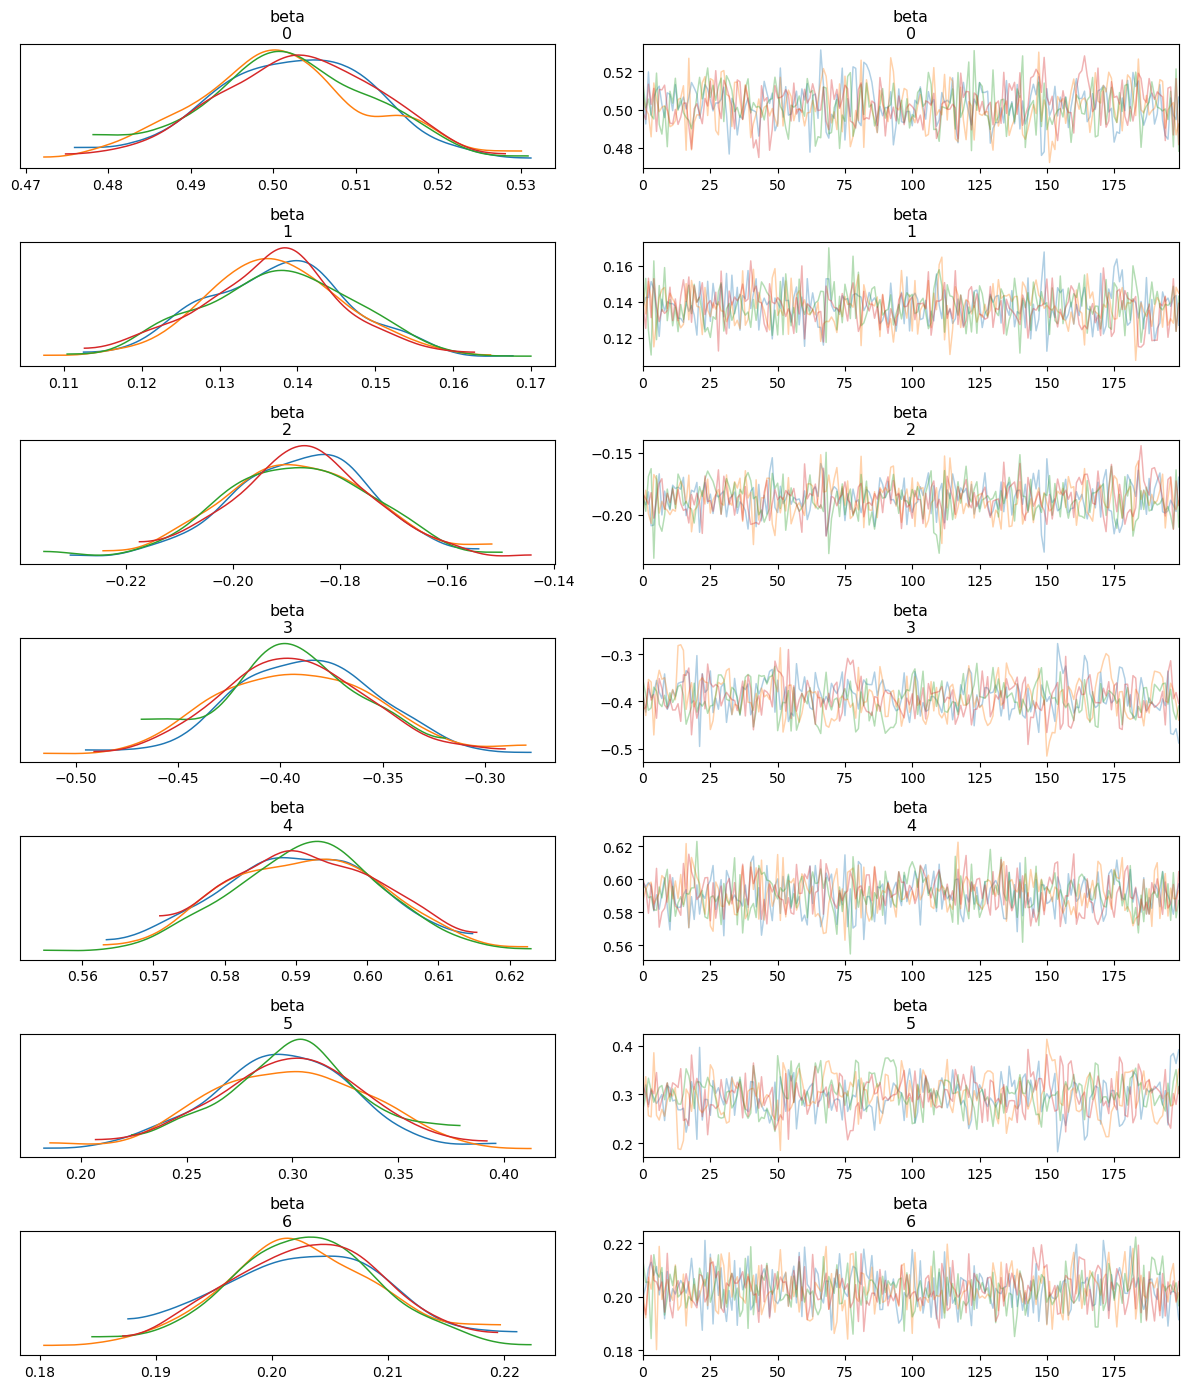

In [25]:
az.plot_trace(posterior_years_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [26]:
log_lik = fit_years.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


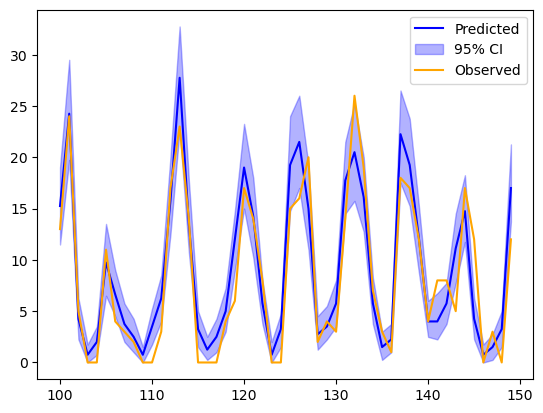

In [27]:
preds_y = posterior_years_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(100, 150)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_120'], label="Observed", color='orange')
plt.legend()
plt.show()

In [28]:
# Crea un oggetto InferenceData contenente log_lik
#inference_years = az.from_cmdstanpy(fit_years, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_years, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_years, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -11159.14   115.20
p_waic       49.97        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11159.38   115.21
p_loo       50.21        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [87]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)
preds_y = posterior_years_az['posterior']['y_pred'].mean(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)

in_ci = np.logical_and(Y['Count_120'] >= y_star_low, Y['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Years'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 44.30%
Mean Absolute Deviation (MAD) sulla mediana: 3.2670572916666667
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         43.880208 -10100.463033 -10100.585184   
1  Modello Variable Selection         35.625000 -10100.463033 -10100.585184   
2               Modello Years         44.296875 -10100.463033 -10100.585184   

   MAD Median  
0    3.785059  
1    5.058691  
2    3.267057  


## Stations factor

After this upgrade, we account for the differences in the *stations* factor.

In [29]:
station_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;

    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ normal(0, 2);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan120/station.stan"

with open(stan_file, "w") as f:
    print(station_model, file=f)

model_station = CmdStanModel(stan_file=stan_file)

15:37:43 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\station.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\station.exe
15:38:10 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\station.exe


In [30]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X
}


fit_stations = model_station.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_station_az = az.from_cmdstanpy(fit_stations)

15:38:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:39:17 - cmdstanpy - INFO - CmdStan done processing.


15:39:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 iterations at max treedepth (4.0%)
	Chain 2 had 17 iterations at max treedepth (8.5%)
	Chain 3 had 2 iterations at max treedepth (1.0%)
	Chain 4 had 7 iterations at max treedepth (3.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


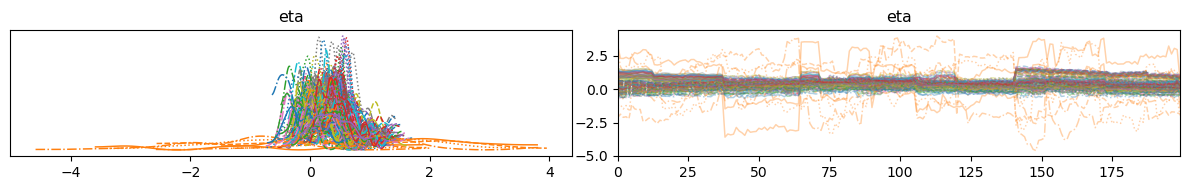

In [31]:
az.plot_trace(posterior_station_az, var_names = ['eta'], compact=True)
plt.tight_layout()
plt.show()

In [32]:

eta = posterior_station_az['posterior']['eta']
eta
len(np.unique(stations))

45

In [33]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

45

In [34]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations_original)
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [35]:
csv_path = '../Datasets/eta_120.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)

In [36]:
log_lik = fit_stations.stan_variable("log_lik")
print(type(log_lik))

<class 'numpy.ndarray'>


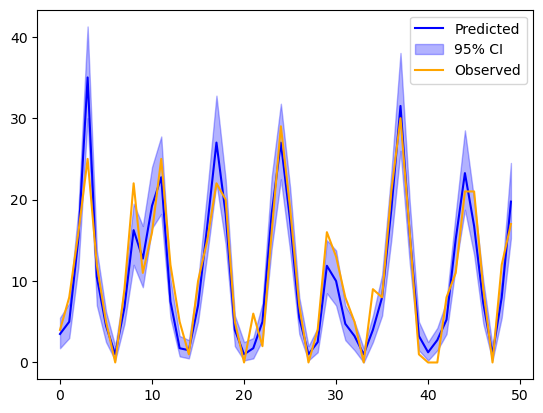

In [37]:
preds_y = posterior_station_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_120'], label="Observed", color='orange')
plt.legend()
plt.show()

In [38]:
sum(y_star_up>30)

207

In [39]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y['Count_120']) | (y_star_up < Y['Count_120']))[0]
print(outliers.shape)

(1924,)


In [40]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_stations, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_stations, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10101.25    86.25
p_waic      101.45        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10101.83    86.25
p_loo      102.03        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [88]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)
preds_y = posterior_station_az['posterior']['y_pred'].mean(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)

in_ci = np.logical_and(Y['Count_120'] >= y_star_low, Y['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Stations'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 49.90%
Mean Absolute Deviation (MAD) sulla mediana: 2.81630859375
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         43.880208 -10100.463033 -10100.585184   
1  Modello Variable Selection         35.625000 -10100.463033 -10100.585184   
2               Modello Years         44.296875 -10100.463033 -10100.585184   
3            Modello Stations         49.895833 -10100.463033 -10100.585184   

   MAD Median  
0    3.785059  
1    5.058691  
2    3.267057  
3    2.816309  


## Proper space model

Now, we should take into account the spatial dependance of the model, through an appropriate space model (main folder with R files) and put again this ideas into this model.

In [66]:
space_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
    matrix[nstations,nstations] H = exp(-(1/(phi^2)) * (distances.^2));

}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
  real<lower = 0> sigma;
}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;
    matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


    fix_eff = X * beta;
    intercept = xi[year] + eta[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 0.35);
}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan120/space.stan"

with open(stan_file, "w") as f:
    print(space_model, file=f)

model_space = CmdStanModel(stan_file=stan_file)

15:47:35 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\space.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\space.exe
15:48:17 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\space.exe


In [43]:
phi = 62/3
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [67]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X,
    "phi": phi,
    "distances": distances
}


fit_space = model_space.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_space_az = az.from_cmdstanpy(fit_space)

15:48:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:48:45 - cmdstanpy - INFO - CmdStan done processing.
15:48:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 35, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 35, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 35, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 35, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 35, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space.stan', line 35, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf 

In [68]:
res = posterior_station_az['posterior']['lambda']

In [69]:
inference = []
for i in range(len(Y['Count_120'])):
    ar1 = res[0, :, i]
    ar2 = res[1, :, i]
    ar3 = res[2, :, i]
    ar4 = res[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)


for i in range(len(inference)):
    inference[i] = np.mean(inference[i])
    
len(inference)
    
inference = inference - Y['Count_120']

In [70]:
df = pd.DataFrame(inference).transpose()
df.shape

(1, 3840)

In [71]:
csv_path = '../Datasets/res_120.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)

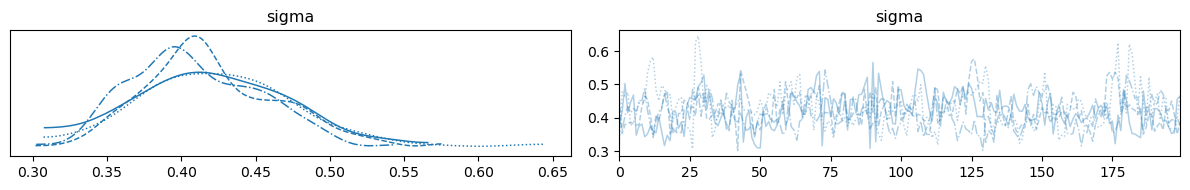

In [72]:
az.plot_trace(posterior_space_az, var_names = ['sigma'], compact=True)
plt.tight_layout()
plt.show()

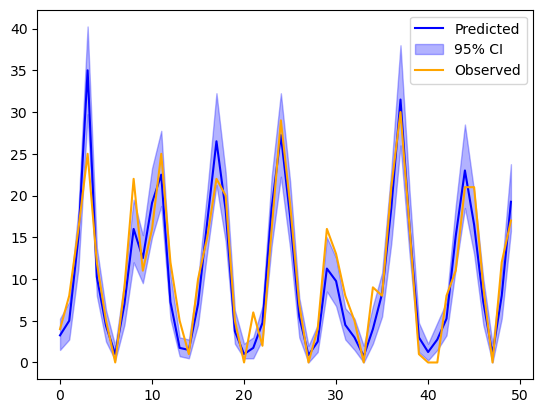

In [73]:
preds_y = posterior_space_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_120'], label="Observed", color='orange')
plt.legend()
plt.show()

In [74]:
sum(y_star_up>30)

207

In [75]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y['Count_120']) | (y_star_up < Y['Count_120']))[0]
print(outliers.shape)

(1927,)


In [76]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_space, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_space, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10100.35    85.91
p_waic       97.56        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10100.92    85.93
p_loo       98.12        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [89]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)
preds_y = posterior_space_az['posterior']['y_pred'].mean(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)

in_ci = np.logical_and(Y['Count_120'] >= y_star_low, Y['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Space1'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 49.82%
Mean Absolute Deviation (MAD) sulla mediana: 2.81845703125
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         43.880208 -10100.463033 -10100.585184   
1  Modello Variable Selection         35.625000 -10100.463033 -10100.585184   
2               Modello Years         44.296875 -10100.463033 -10100.585184   
3            Modello Stations         49.895833 -10100.463033 -10100.585184   
4              Modello Space1         49.817708 -10100.463033 -10100.585184   

   MAD Median  
0    3.785059  
1    5.058691  
2    3.267057  
3    2.816309  
4    2.818457  


In [61]:
space_model_bis = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;

  array[N] int<lower=1> year;
  array[N] int<lower=1> stations;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
  real phi;
  matrix[nstations, nstations] distances;
}

transformed data {
    matrix[nstations,nstations] H = exp(-(1/(phi^2)) * (distances.^2));

}

parameters {
  vector[P] beta; // Coefficients for predictors
  vector[nyears] xi; // Random effects for years
  vector[nstations] eta;//For the stations
  vector[nstations] w; //Random zero-mean effect for the space model
  real<lower = 0> sigma;
  real<lower = 0> sigma0;

}

transformed parameters {
    vector[N] lambda;
    vector[N] fix_eff;
    vector[N] intercept;
    matrix[nstations,nstations] Sigma_s = sigma * sigma * H; //To be added the variance
    matrix[nstations,nstations] Lw = cholesky_decompose(Sigma_s);


    fix_eff = X * beta;
    intercept = xi[year] + eta[stations] + w[stations];

    lambda = exp(fix_eff + intercept);
}

model {

  beta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);

  xi ~ normal(0, 2);
  eta ~ normal(0, sigma0);
  w ~ multi_normal_cholesky(rep_vector(0, nstations), Lw);
  sigma ~ inv_gamma(2, 2);
  sigma0 ~ inv_gamma(2, 2);

}
generated quantities{
 vector[N] log_lik;
 vector[N] y_pred;
 
 for(i in 1:N){
   log_lik[i] = poisson_lpmf(y[i]|lambda[i]);
   y_pred[i] = poisson_rng(lambda[i]);
}
}

"""

stan_file = "./stan120/space_bis.stan"

with open(stan_file, "w") as f:
    print(space_model_bis, file=f)

model_space_bis = CmdStanModel(stan_file=stan_file)

15:44:38 - cmdstanpy - INFO - compiling stan file C:\Users\leoma\OneDrive\DOCUME~1\PoliMi\BAYESI~1\BAYESI~1\main\Modello\stan\space_bis.stan to exe file C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\space_bis.exe
15:45:20 - cmdstanpy - INFO - compiled model executable: C:\Users\leoma\OneDrive\Documents\PoliMi\Bayesian statistics\Bayesian_Project\main\Modello\stan\space_bis.exe


In [78]:
data = {
    "N": len(Y),
    "P": X.shape[1],
    "nyears": 13,
    "nstations": 45,
    "stations": stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X,
    "phi": phi,
    "distances": distances
}


fit_space_bis = model_space_bis.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=2000, iter_sampling=3000)
posterior_space_bis_az = az.from_cmdstanpy(fit_space_bis)

15:50:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:01:10 - cmdstanpy - INFO - CmdStan done processing.
16:01:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 38, column 4 to column 65)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'space_bis.stan', line 38, column 4 to column 65)
Exception: cholesky_decompose: A is not symmetric. A[1,2] 

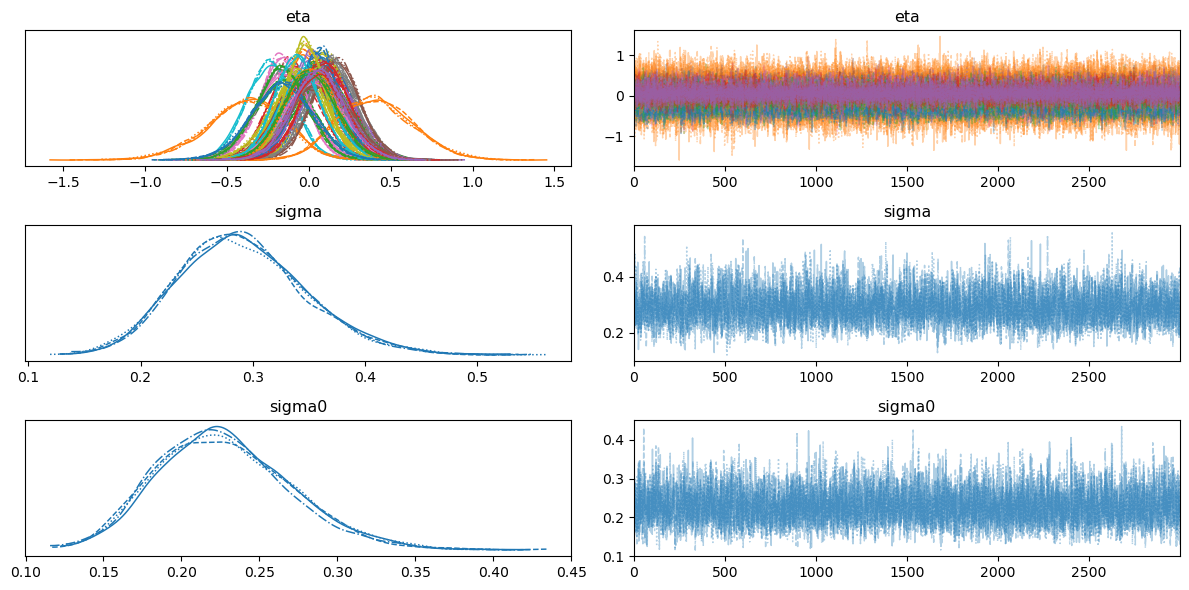

In [79]:
az.plot_trace(posterior_space_bis_az, var_names = ['eta', 'sigma', 'sigma0'], compact=True)
plt.tight_layout()
plt.show()

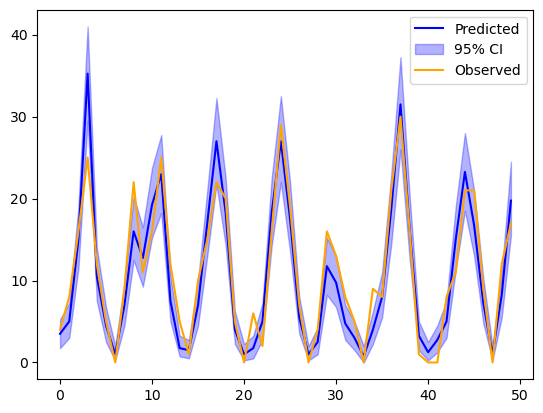

In [80]:
preds_y = posterior_space_bis_az['posterior']['y_pred'].mean(axis=0)
y_star = preds_y.median(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)
xx = np.arange(0, 50)
plt.plot(xx, y_star[xx], label="Predicted", color='blue')
plt.fill_between(xx, y_star_low[xx], y_star_up[xx], alpha=0.3, label="95% CI", color='blue')
plt.plot(xx, Y.loc[xx, 'Count_120'], label="Observed", color='orange')
plt.legend()
plt.show()

In [81]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y['Count_120']) | (y_star_up < Y['Count_120']))[0]
print(outliers.shape)

(1883,)


In [82]:
sum(y_star_up>30)

207

In [83]:
# Crea un oggetto InferenceData contenente log_lik
#inference_stations = az.from_cmdstanpy(fit_stations, log_likelihood={"log_lik": log_lik})

# Calcola e stampa WAIC
waic_result = az.waic(fit_space_bis, var_name="log_lik")
print("WAIC: ", waic_result)

# Calcola e stampa LOO
loo_result = az.loo(fit_space_bis, var_name="log_lik")
print("LOO: ", loo_result)

C:\Users\leoma\anaconda3\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC:  Computed from 12000 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10100.46    86.03
p_waic      100.01        -

There has been a warning during the calculation. Please check the results.
LOO:  Computed from 12000 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10100.59    86.04
p_loo      100.13        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [90]:
# Percentuale di osservazioni appartenenti al Credible Interval (95%)
preds_y = posterior_space_bis_az['posterior']['y_pred'].mean(axis=0)
y_star_up = np.percentile(preds_y, 97.5, axis=0)
y_star_low = np.percentile(preds_y, 2.5, axis=0)

in_ci = np.logical_and(Y['Count_120'] >= y_star_low, Y['Count_120'] <= y_star_up)

# Calcola la percentuale di osservazioni che appartengono al CI
percentage_in_ci = np.sum(in_ci) / len(Y) * 100

print(f"Percentage of Observed in 95% CI: {percentage_in_ci:.2f}%")

# Calcolo Mean Absolute Deviation rispetto alla mediana
median_predictions = np.median(preds_y, axis=0)

# Calcola la deviazione assoluta di ogni punto dati dalla mediana delle predizioni
absolute_deviations = np.abs(Y['Count_120'] - median_predictions)

# Calcola la MAD sulla mediana media su tutte le osservazioni
mad_median = np.mean(absolute_deviations).item()

print("Mean Absolute Deviation (MAD) sulla mediana:", mad_median)

# Aggiungi una riga per il modello corrente (posterior_base_az)
model_name = 'Modello Space2'
new_data = pd.DataFrame({
    'Model': [model_name],
    'Percentage in CI': [percentage_in_ci],
    'WAIC': [waic_result.elpd_waic.item()],
    'LOO': [loo_result.elpd_loo.item()],
    'MAD Median': [mad_median]
})

# Concatena il nuovo DataFrame con quello esistente
results_df = pd.concat([results_df, new_data], ignore_index=True)

# Visualizza il DataFrame
print(results_df)

Percentage of Observed in 95% CI: 50.96%
Mean Absolute Deviation (MAD) sulla mediana: 2.81884765625
                        Model  Percentage in CI          WAIC           LOO  \
0                Modello Base         43.880208 -10100.463033 -10100.585184   
1  Modello Variable Selection         35.625000 -10100.463033 -10100.585184   
2               Modello Years         44.296875 -10100.463033 -10100.585184   
3            Modello Stations         49.895833 -10100.463033 -10100.585184   
4              Modello Space1         49.817708 -10100.463033 -10100.585184   
5              Modello Space2         50.963542 -10100.463033 -10100.585184   

   MAD Median  
0    3.785059  
1    5.058691  
2    3.267057  
3    2.816309  
4    2.818457  
5    2.818848  
